# Android Malware Analysis

## Android


Android is one of the most used mobile operating systems worldwide. Due to its technological impact, its open-source code and the possibility of installing applications from third parties without any central control, Android has recently become a malware target. Even if it includes security mechanisms, the last news about malicious activities and Android´s vulnerabilities point to the importance of continuing the development of methods and frameworks to improve its security.

To prevent malware attacks, researches and developers have proposed different security solutions, applying static analysis, dynamic analysis, and artificial intelligence. Indeed, data science has become a promising area in cybersecurity, since analytical models based on data allow for the discovery of insights that can help to predict malicious activities.

We can analyze cyber threats using two techniques, static analysis, and dynamic analysis, the most important thing is that these are the approaches to get the features that we are going to use in data science.

+ **Static analysis**: it includes the methods that allow us to get information about the software that we want to analyze without executing it, one example of them is the study of the code, their callings, resources, etc.
+ **Dynamic analysis**: it is another approach where the idea is to analyze the cyber threat during its execution, in other words, get information about its behavior, some of their features are the netflows.


# State of the Art

In 2016 we published an article [2] about the state of the art of frameworks and results about Android malware detection. This work reflects different static analysis tools (TaintDroid, Stowaway, Crowdroid y Airmid), dynamic analysis systems (Paranoid and DroidMOSS), frameworks (MobSafe, SAAF, and ASEF) and some research results about using machine learning. From this article we concluded that the idea is using both static and dynamic analysis in order to get spectra of features, moreover, some works have been working to use virtual devices in the cloud.


# Datasets

In 2016 we explored [3] Android Genome Project (MalGenome), it is a dataset which was active from 2012 until the end of the year 2015, this set of malware has a size of 1260 applications, grouped into a total of 49 families. Today, we can find other jobs such as: Drebin, a research project offering a total of 5560 applications consisting of 179 malware families; AndrooZoo, which includes a collection of 5669661 applications Android from different sources (including Google Play); VirusShare, another repository that provides samples of malware for cybersecurity researchers; and DroidCollector, this is another set which provides around 8000 benign applications and 5560 malware samples, moreover, it facilitates us samples of network traffic as pcap files.

# Static Analysis 

In this first step, I'm going to analyze some features in order to answer the next hypothesis, *exist a differential of the permissions used between a set of malware and benign samples*, in other words… 

<img src="https://pics.me.me/when-the-flashlight-app-wants-access-to-your-call-history-32812256.png" height="250" width="250">

For this approach, I developed a code that consisted to extract and make a CSV file which has information about permissions of applications, through this script you can map each APK (Android Application Package) against a list of permissions. You can find more information about the proposed framework at [3]

https://github.com/urcuqui/WhiteHat

### Packages

In [1]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
import torch
from sklearn import svm
from sklearn import tree
import pandas as pd
from sklearn.externals import joblib
import pickle
import numpy as np
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


### Exploratory 

For the next analysis, I'm going to explore the Malgenome dataset, as I said nowadays we can find other sources with a lot of examples and malware families which would be important for future works, the idea of the next experiment and results is to show our first approached.

<img src="https://ieee-dataport.org/sites/default/files/styles/large/public/Sin%20t%C3%ADtulo.png?itok=4YoQim00" /> 

*It is not neccesary to apply a data cleaning and transformation process*

In [ ]:
import pandas as pd
df = pd.read_csv("../input/datasetandroidpermissions/train.csv", sep=";")

In [ ]:
df = df.astype("int64")
df.type.value_counts()

Type is the label that represents if an application is a malware or not, as we can see this dataset is balanced.

In [ ]:
df.shape

*Let's get the top 10 of permissions that are used for our malware samples*

*Malicious*

In [ ]:
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[1:11]

*Benign*

In [ ]:
pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[:10]

In [ ]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(nrows=2, sharex=True)

pd.Series.sort_values(df[df.type==0].sum(axis=0), ascending=False)[:10].plot.bar(ax=axs[0])
pd.Series.sort_values(df[df.type==1].sum(axis=0), ascending=False)[1:11].plot.bar(ax=axs[1], color="red")

The last outputs allow us to get insights about a difference between the permissions used by the malware and the benign applications.

### Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:330], df['type'], test_size=0.20, random_state=42)

*Naive Bayes algorithm*

In [ ]:
#Cross validation
X_train=df.iloc[:, 1:330]
y_train=df['type']
gnb = GaussianNB()

def custom_cross_validation1(model, X_train, y_train, cv):
    my_pipeline = make_pipeline(Imputer(), model)
    scores = cross_val_score(my_pipeline, X_train, y_train, cv=cv)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    return scores

#sc=custom_cross_validation(gnb, X_train, y_train, cv=10)

In [2]:
#R square
def r2(y_true,y_pred):
    m_t_v=np.mean(y_true)
    numerator=0
    denominator=0
    for yt,yp in zip(y_true,y_pred):
        numerator +=(yt-yp)**2
        denominator +=(yt-m_t_v)**2
    r=numerator/denominator
    return 1-r

In [3]:
#MCC
def mcc(y_true,y_pred):
    #tp=true_positive(y_true,y_pred)
    #tn=true_negative(y_true,y_pred)
    #fp=false_positive(y_true,y_pred)
    #fn=false_negative(y_true,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    n=(tp*tn)-(fp*fn)
    d=((tp+fp)*(fn+tn)*(fp+tn)*(tp+fn))
    d=d**0.5
    r=n/d
    return r

In [4]:
def scoreset(y_true,y_pred):
    score_set=[]
    pred=y_pred
    y_test=y_true
    print("cohen kappa score",cohen_kappa_score(y_test, pred))
    score_set.append(cohen_kappa_score(y_test, pred))
    print("cohen kappa score quadratic",cohen_kappa_score(y_test, pred, weights="quadratic"))
    score_set.append(cohen_kappa_score(y_test, pred, weights="quadratic"))
    print("R square score", r2(y_test,pred))
    score_set.append(r2(y_test,pred))
    print("MCC score", mcc(y_test,pred))
    score_set.append(mcc(y_test,pred))
    print("Brier Score Loss",brier_score_loss(y_test, pred))
    score_set.append(brier_score_loss(y_test, pred))
    print("AUC ROC Score",roc_auc_score(y_test, pred))
    score_set.append(roc_auc_score(y_test, pred))
    print("")
    print("accuracy:",accuracy_score(y_test,pred))
    score_set.append(accuracy_score(y_test,pred))
    print("F1 Score:",f1_score(y_test,pred))
    score_set.append(f1_score(y_test,pred))
    print("Precision:",precision_score(y_test,pred))
    score_set.append(precision_score(y_test,pred))
    print("Recall:",recall_score(y_test,pred))
    score_set.append(recall_score(y_test,pred))
    return score_set
    

In [ ]:
# Naive Bayes algorithm
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# pred
pred = gnb.predict(X_test)

# accuracy
accuracy = accuracy_score(pred, y_test)
print("naive_bayes")
print(classification_report(pred, y_test, labels=None))


#print("cohen kappa score",cohen_kappa_score(y_test, pred))
#print("cohen kappa score quadratic",cohen_kappa_score(y_test, pred, weights="quadratic"))
#print("R square score", r2(y_test,pred))
#print("MCC score", mcc(y_test,pred))
#print("Brier Score Loss",brier_score_loss(y_test, pred))
#print("AUC ROC Score",roc_auc_score(y_test, pred))
#print("")
#print("accuracy:",accuracy)
#print("F1 Score:",f1_score(pred, y_test))
#print("Precision:",precision_score(pred, y_test))
#print("Recall:",recall_score(pred, y_test))

s=scoreset(y_test,pred)
#print(s)

*kneighbors algorithm*

In [ ]:
# kneighbors algorithm

for i in range(3,15,3):
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    # accuracy
    accuracy = accuracy_score(pred, y_test)
    print("kneighbors {}".format(i))
    print(accuracy)
    print(classification_report(pred, y_test, labels=None))
    s=scoreset(y_test,pred)
    
    

*Decision Tree*

In [ ]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Read the csv test file

pred = clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(clf)
print(accuracy)
print(classification_report(pred, y_test, labels=None))
s=scoreset(y_test,pred)

In [ ]:
#LinearSVM
from sklearn import svm

lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)
pred = lin_clf.predict(X_test)
# accuracy
accuracy = accuracy_score(pred, y_test)
print(accuracy)
print(classification_report(pred, y_test, labels=None))
s=scoreset(y_test,pred)

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)
pred=xgb_clf.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
s=scoreset(y_test,pred)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred=clf.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)
pred=pred.astype("int64")
s=scoreset(y_test,pred)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.3)#vary the learning rate from 0 to 1.5
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
pred = model.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)
pred=pred.astype("int64")
s=scoreset(y_test,pred)

In [ ]:
rdF=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdF.fit(X_train,y_train)
pred=rdF.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)
pred=pred.astype("int64")
s=scoreset(y_test,pred)

In [ ]:


# Two features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k = 300) 
X_kbest_features = chi2_features.fit_transform(X_train.astype(), y_train) 
  
# Reduced features 
print('Original feature number:', X_train.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 
print(X_kbest_features)

Through the last results we can see how we trained different classifiers to detect malware using its permissions, but as I said this is only a first approximation, I didn't analyze the hyperparameters and others things to improve the results.

# Dynamic Analysis

For this approach, we used a set of pcap files from the DroidCollector project integrated by 4705 benign and 7846 malicious applications. All of the files were processed by our feature extractor script (a result from [4]), the idea of this analysis is to answer the next question, according to the static analysis previously seen a lot of applications use a network connection, in other words, they are trying to communicate or transmit information, so.. is it possible to distinguish between malware and benign application using network traffic?

In [5]:
import pandas as pd
data = pd.read_csv("../input/network-traffic-android-malware/android_traffic.csv", sep=";")
data.head()

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [6]:
#replacing null with 0
data.fillna(0)

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,0.0,0.0,0.0,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,0.0,0.0,0.0,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,0.0,0.0,0.0,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,0.0,0.0,0.0,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,0.0,0.0,0.0,7,1,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,Zsone,0,0,0,0,0,0,2,2,257,143,0.0,0.0,0.0,2,2,malicious
7841,Zsone,4,4,1,296,0,0,5,1,86,382,0.0,0.0,0.0,5,1,malicious
7842,Zsone,0,0,0,0,0,0,2,2,257,143,0.0,0.0,0.0,2,2,malicious
7843,Zsone,0,0,0,0,0,0,2,2,257,143,0.0,0.0,0.0,2,2,malicious


In [7]:
data.columns

Index(['name', 'tcp_packets', 'dist_port_tcp', 'external_ips', 'vulume_bytes',
       'udp_packets', 'tcp_urg_packet', 'source_app_packets',
       'remote_app_packets', 'source_app_bytes', 'remote_app_bytes',
       'duracion', 'avg_local_pkt_rate', 'avg_remote_pkt_rate',
       'source_app_packets.1', 'dns_query_times', 'type'],
      dtype='object')

In [8]:
data.shape

(7845, 17)

In [9]:
##encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data['type'])
data['type'] = le.transform(data['type'])
#print(data['type'])

In [10]:
data.type.value_counts()

0    4704
1    3141
Name: type, dtype: int64

In this case, we have an unbalanced dataset, so another model evaluation will be used.(4704,3141)

### Data Cleaning and Processing

In [11]:
data.isna().sum()

name                       0
tcp_packets                0
dist_port_tcp              0
external_ips               0
vulume_bytes               0
udp_packets                0
tcp_urg_packet             0
source_app_packets         0
remote_app_packets         0
source_app_bytes           0
remote_app_bytes           0
duracion                7845
avg_local_pkt_rate      7845
avg_remote_pkt_rate     7845
source_app_packets.1       0
dns_query_times            0
type                       0
dtype: int64

When we processed each pcap we had some problems getting three features (duration, avg remote package rate, avg local package rate) this why got during the feature processing script, we don't have this issue nowadays. 

In [12]:
data = data.drop(['duracion','avg_local_pkt_rate','avg_remote_pkt_rate'], axis=1).copy()

In [13]:
data.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,7845.000000,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,152.911918,4.898917,0.400382
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,779.034618,18.900478,0.490007
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,1.000000,0.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,7.000000,1.000000,0.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,30.000000,3.000000,0.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,98.000000,5.000000,1.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,37150.000000,913.000000,1.000000


Now, the idea is to see the outliers in the data

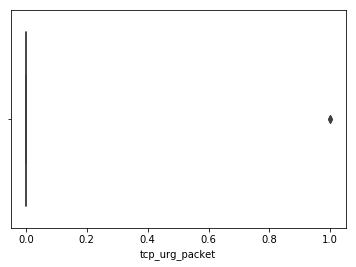

In [14]:
sns.boxplot(data.tcp_urg_packet)

In [15]:
data.loc[data.tcp_urg_packet > 0].shape[0]

2

That column will be no used for the analysis, only two rows are different to zero, maybe they are interesting for future analysis.

In [ ]:
#data = data.drop(['duracion','avg_local_pkt_rate','avg_remote_pkt_rate'], axis=1).copy()
X,y=data.iloc[:,1:17].astype("int"), data.type.astype("int")
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [16]:
data = data.drop(columns=["tcp_urg_packet"], axis=1).copy()
data.shape

(7845, 13)

In [ ]:
sns.pairplot(data)

We have many outliers in some features, I will omit the depth analysis and only get the set of the data without the noise. 

In [17]:
data=data[data.tcp_packets<20000].copy()
data=data[data.dist_port_tcp<1400].copy()
data=data[data.external_ips<35].copy()
data=data[data.vulume_bytes<2000000].copy()
data=data[data.udp_packets<40].copy()
data=data[data.remote_app_packets<15000].copy()

In [18]:
data[data.duplicated()].sum()

name                    AntiVirusAntiVirusAntiVirusAntiVirusAntiVirusA...
tcp_packets                                                         15038
dist_port_tcp                                                        3514
external_ips                                                         1434
vulume_bytes                                                      2061210
udp_packets                                                            38
source_app_packets                                                  21720
remote_app_packets                                                  18841
source_app_bytes                                                  8615120
remote_app_bytes                                                  2456160
source_app_packets.1                                                21720
dns_query_times                                                      5095
type                                                                 1268
dtype: object

In [19]:
data=data.drop('source_app_packets.1',axis=1).copy()

In [20]:
scaler = preprocessing.RobustScaler()
scaledData = scaler.fit_transform(data.iloc[:,1:11])
scaledData = pd.DataFrame(scaledData, columns=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes','udp_packets','source_app_packets','remote_app_packets',' source_app_bytes','remote_app_bytes','dns_query_times'])

From [6] we concluded that the best network features are:

+ (R1): TCP packets, it has the number of packets TCP sent and got during communication.
+ (R2): Different TCP packets, it is the total number of packets different from TCP.
+ (R3): External IP, represents the number the external addresses (IPs) where the application tried to communicated
+ (R4): Volume of bytes, it is the number of bytes that was sent from the application to the external sites
+ (R5) UDP packets, the total number of packets UDP transmitted in a communication.
+ (R6) Packets of the source application, it is the number of packets that were sent from the application to a remote server.
+ (R7) Remote application packages, number of packages received from external sources.
+ (R8) Bytes of the application source, this is the volume (in Bytes) of the communication between the application and server.
+ (R9) Bytes of the application remote, this is the volume (in Bytes) of the data from the server to the emulator.
+ (R10) DNS queries, number of DNS queries.


In [ ]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2

X_train,y_train=scaledData.iloc[:,0:10].astype("int"), data.type.astype("int")
# Two features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k = 8) 
X_kbest_features = chi2_features.fit_transform(X_train, y_train) 
  
# Reduced features 
print('Original feature number:', X_train.shape[1], X_train.columns) 
print('Reduced feature number:', X_kbest_features.shape[1])


In [ ]:

X,y=scaledData.iloc[:,0:10].astype("int"), data.type.astype("int")
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

Since dns_query_times has higher the p-value, it says that this variables is independent of the reponse and can not be considered for model training

In [ ]:
#optional
scaledData.shape
scaledData = scaledData.drop(columns=["dns_query_times"], axis=1).copy()
scaledData.shape

### Modeling

In [34]:
X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:10], data.type.astype("str"), test_size=0.25, random_state=45)
#X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:9], data.type.astype("str"), test_size=0.25, random_state=45)

In [35]:
y1_test=y_test.astype("int64")

In [ ]:
#LinearSVM
from sklearn import svm

lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)
pred = lin_clf.predict(X_test)
pred=pred.astype("int64")
## accuracy
s=scoreset(y1_test,pred)
#print(s)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)

pred=pred.astype("int64")
## accuracy
s=scoreset(y1_test,pred)

In [ ]:
# kneighbors algorithm

for i in range(3,15,3):
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    pred = neigh.predict(X_test)
    pred=pred.astype("int64")
    # accuracy
    accuracy = accuracy_score(pred, y1_test)
    print("kneighbors {}".format(i))
    s=scoreset(y1_test,pred)

In [ ]:
rdF=RandomForestClassifier(n_estimators=250, max_depth=50,random_state=45)
rdF.fit(X_train,y_train)
pred=rdF.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(rdF)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)
pred=pred.astype("int64")
s=scoreset(y1_test,pred)

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)
pred=xgb_clf.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)
pred=pred.astype("int64")
s=scoreset(y1_test,pred)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.3)#vary the learning rate from 0 to 1.5
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
pred = model.predict(X_test)
cm=confusion_matrix(y_test, pred)

accuracy = accuracy_score(y_test,pred)
print(accuracy)
print(classification_report(y_test,pred, labels=None))
print("cohen kappa score")
print(cohen_kappa_score(y_test, pred))
print(cm)
pred=pred.astype("int64")
s=scoreset(y1_test,pred)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred=clf.predict(X_test)
#cm=confusion_matrix(y1_test, pred)

#accuracy = accuracy_score(y1_test,pred)
#print(accuracy)
#print(classification_report(y1_test,pred, labels=None))
pred=pred.astype("int64")
s=scoreset(y1_test,pred)

In [36]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
print(len(y_test))
print(y_test[0:100])

1958
[1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0
 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# create model
model = Sequential()
model.add(Dense(14, input_dim=10, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# create model
model = Sequential()
model.add(Dense(14, input_dim=10, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


In [ ]:
#Neural network module
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils

# create model
model = Sequential()
model.add(Dense(14, input_dim=10, kernel_initializer='uniform', activation='relu'))
model.add(Dense(12, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
######best one with 87% ACC and good graphs
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
import matplotlib.pyplot as plt
import numpy
model=Sequential()
model.add(Dense(1000,input_dim=10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
#model.add(Dense(3,activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [38]:
######best one with 87% ACC and good graphs for 500 epochs and 0.10 split
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
import matplotlib.pyplot as plt
import numpy
model=Sequential()
model.add(Dense(1000,input_dim=10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(700,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])

# Fit the model
print('training')
history = model.fit(X_train, y_train, validation_split=0.10, epochs=500, batch_size=100, verbose=1)
print('over')

##test dataset
y_pred = model.predict(X_test)
#y_pred=np.argmax(y_pred,axis=-1)
y_pred=np.where(y_pred> 0.5, 1, 0)
#print(y_pred[0:5])
y_true=y_test
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score
#tp, fp, fn, tn = confusion_matrix(y_true,y_pred)
acc=accuracy_score(y_true, y_pred)
precision=precision_score(y_true, y_pred, average='weighted')
f1=f1_score(y_true, y_pred, average='weighted')
print('Accuracy=',acc)
print('Precision=',precision)
print('F1Score=',f1)
print('tn, fp, fn, tp' )

from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['0','1'])
print(report)
print(confusion_matrix(y_true,y_pred))

s=scoreset(y_true,y_pred)
plot_graph_train_val(history)

training
Train on 5286 samples, validate on 588 samples
Epoch 1/500
5286/5286 [==============================] - 1s 104us/step - loss: 0.7007 - accuracy: 0.5885 - val_loss: 0.7078 - val_accuracy: 0.4643
Epoch 2/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.7024 - accuracy: 0.5832 - val_loss: 0.6677 - val_accuracy: 0.5850
Epoch 3/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.6646 - accuracy: 0.5948 - val_loss: 0.6659 - val_accuracy: 0.5850
Epoch 4/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.6682 - accuracy: 0.5959 - val_loss: 0.6616 - val_accuracy: 0.5867
Epoch 5/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.6654 - accuracy: 0.5991 - val_loss: 0.6643 - val_accuracy: 0.5850
Epoch 6/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.6623 - accuracy: 0.5972 - val_loss: 0.6609 - val_accuracy: 0.5850
Epoch 7/500
5286/5286 [==============================] - 0s 35us/st

5286/5286 [==============================] - 0s 36us/step - loss: 0.5443 - accuracy: 0.7261 - val_loss: 0.5754 - val_accuracy: 0.7143
Epoch 57/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.5412 - accuracy: 0.7281 - val_loss: 0.5763 - val_accuracy: 0.7126
Epoch 58/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.5386 - accuracy: 0.7281 - val_loss: 0.5789 - val_accuracy: 0.7109
Epoch 59/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.5378 - accuracy: 0.7266 - val_loss: 0.5682 - val_accuracy: 0.7194
Epoch 60/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.5367 - accuracy: 0.7304 - val_loss: 0.5720 - val_accuracy: 0.7126
Epoch 61/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.5325 - accuracy: 0.7306 - val_loss: 0.5735 - val_accuracy: 0.7109
Epoch 62/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.5327 - accuracy: 0.7285 - val_loss: 0.5698 - val_a

Epoch 112/500
5286/5286 [==============================] - 0s 39us/step - loss: 0.4715 - accuracy: 0.7707 - val_loss: 0.5087 - val_accuracy: 0.7619
Epoch 113/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4748 - accuracy: 0.7719 - val_loss: 0.5002 - val_accuracy: 0.7585
Epoch 114/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4751 - accuracy: 0.7664 - val_loss: 0.4980 - val_accuracy: 0.7602
Epoch 115/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4734 - accuracy: 0.7698 - val_loss: 0.5026 - val_accuracy: 0.7602
Epoch 116/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4711 - accuracy: 0.7705 - val_loss: 0.4864 - val_accuracy: 0.7721
Epoch 117/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.4727 - accuracy: 0.7787 - val_loss: 0.5027 - val_accuracy: 0.7670
Epoch 118/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4648 - accuracy: 0.7736 - val_

5286/5286 [==============================] - 0s 38us/step - loss: 0.4406 - accuracy: 0.7932 - val_loss: 0.4500 - val_accuracy: 0.7857
Epoch 168/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4356 - accuracy: 0.7940 - val_loss: 0.4506 - val_accuracy: 0.7755
Epoch 169/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.4358 - accuracy: 0.7927 - val_loss: 0.4432 - val_accuracy: 0.7823
Epoch 170/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.4320 - accuracy: 0.7923 - val_loss: 0.4509 - val_accuracy: 0.7840
Epoch 171/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4331 - accuracy: 0.7925 - val_loss: 0.4452 - val_accuracy: 0.7857
Epoch 172/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4350 - accuracy: 0.7944 - val_loss: 0.4514 - val_accuracy: 0.7772
Epoch 173/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.4314 - accuracy: 0.7953 - val_loss: 0.4461 -

5286/5286 [==============================] - 0s 35us/step - loss: 0.4064 - accuracy: 0.8156 - val_loss: 0.4276 - val_accuracy: 0.8129
Epoch 223/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.4062 - accuracy: 0.8108 - val_loss: 0.4268 - val_accuracy: 0.8214
Epoch 224/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.4114 - accuracy: 0.8129 - val_loss: 0.4163 - val_accuracy: 0.8163
Epoch 225/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.4005 - accuracy: 0.8176 - val_loss: 0.4206 - val_accuracy: 0.8163
Epoch 226/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.4122 - accuracy: 0.8163 - val_loss: 0.4268 - val_accuracy: 0.8010
Epoch 227/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.4008 - accuracy: 0.8212 - val_loss: 0.4212 - val_accuracy: 0.8163
Epoch 228/500
5286/5286 [==============================] - 0s 40us/step - loss: 0.4063 - accuracy: 0.8140 - val_loss: 0.4359 -

5286/5286 [==============================] - 0s 39us/step - loss: 0.3828 - accuracy: 0.8331 - val_loss: 0.4114 - val_accuracy: 0.8248
Epoch 278/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.3838 - accuracy: 0.8318 - val_loss: 0.4183 - val_accuracy: 0.8299
Epoch 279/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3851 - accuracy: 0.8292 - val_loss: 0.4031 - val_accuracy: 0.8350
Epoch 280/500
5286/5286 [==============================] - 0s 40us/step - loss: 0.3834 - accuracy: 0.8309 - val_loss: 0.4240 - val_accuracy: 0.8044
Epoch 281/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.3814 - accuracy: 0.8277 - val_loss: 0.4035 - val_accuracy: 0.8333
Epoch 282/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.3845 - accuracy: 0.8316 - val_loss: 0.4056 - val_accuracy: 0.8214
Epoch 283/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.3794 - accuracy: 0.8326 - val_loss: 0.4226 -

5286/5286 [==============================] - 0s 39us/step - loss: 0.3663 - accuracy: 0.8354 - val_loss: 0.3933 - val_accuracy: 0.8316
Epoch 333/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.3718 - accuracy: 0.8375 - val_loss: 0.3908 - val_accuracy: 0.8316
Epoch 334/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.3577 - accuracy: 0.8377 - val_loss: 0.3961 - val_accuracy: 0.8197
Epoch 335/500
5286/5286 [==============================] - 0s 38us/step - loss: 0.3625 - accuracy: 0.8371 - val_loss: 0.3837 - val_accuracy: 0.8418
Epoch 336/500
5286/5286 [==============================] - 0s 38us/step - loss: 0.3705 - accuracy: 0.8345 - val_loss: 0.3897 - val_accuracy: 0.8265
Epoch 337/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.3665 - accuracy: 0.8381 - val_loss: 0.3858 - val_accuracy: 0.8401
Epoch 338/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.3612 - accuracy: 0.8396 - val_loss: 0.3862 -

5286/5286 [==============================] - 0s 34us/step - loss: 0.3519 - accuracy: 0.8468 - val_loss: 0.3885 - val_accuracy: 0.8418
Epoch 388/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.3469 - accuracy: 0.8519 - val_loss: 0.3820 - val_accuracy: 0.8384
Epoch 389/500
5286/5286 [==============================] - 0s 35us/step - loss: 0.3462 - accuracy: 0.8475 - val_loss: 0.3854 - val_accuracy: 0.8384
Epoch 390/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3584 - accuracy: 0.8439 - val_loss: 0.4035 - val_accuracy: 0.8316
Epoch 391/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3510 - accuracy: 0.8462 - val_loss: 0.3799 - val_accuracy: 0.8367
Epoch 392/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.3442 - accuracy: 0.8454 - val_loss: 0.3994 - val_accuracy: 0.8282
Epoch 393/500
5286/5286 [==============================] - 0s 34us/step - loss: 0.3432 - accuracy: 0.8496 - val_loss: 0.3903 -

5286/5286 [==============================] - 0s 37us/step - loss: 0.3300 - accuracy: 0.8577 - val_loss: 0.3877 - val_accuracy: 0.8384
Epoch 443/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3311 - accuracy: 0.8553 - val_loss: 0.3652 - val_accuracy: 0.8452
Epoch 444/500
5286/5286 [==============================] - 0s 37us/step - loss: 0.3434 - accuracy: 0.8545 - val_loss: 0.3849 - val_accuracy: 0.8469
Epoch 445/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3364 - accuracy: 0.8555 - val_loss: 0.3636 - val_accuracy: 0.8537
Epoch 446/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3315 - accuracy: 0.8519 - val_loss: 0.3794 - val_accuracy: 0.8486
Epoch 447/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3332 - accuracy: 0.8519 - val_loss: 0.3767 - val_accuracy: 0.8367
Epoch 448/500
5286/5286 [==============================] - 0s 39us/step - loss: 0.3417 - accuracy: 0.8490 - val_loss: 0.3888 -

5286/5286 [==============================] - 0s 36us/step - loss: 0.3265 - accuracy: 0.8568 - val_loss: 0.3777 - val_accuracy: 0.8537
Epoch 498/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3241 - accuracy: 0.8540 - val_loss: 0.3625 - val_accuracy: 0.8554
Epoch 499/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3282 - accuracy: 0.8583 - val_loss: 0.3956 - val_accuracy: 0.8401
Epoch 500/500
5286/5286 [==============================] - 0s 36us/step - loss: 0.3218 - accuracy: 0.8619 - val_loss: 0.3630 - val_accuracy: 0.8588
over
Accuracy= 0.8707865168539326
Precision= 0.8707570769560161
F1Score= 0.8707715620602494
tn, fp, fn, tp
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1190
           1       0.84      0.83      0.84       768

    accuracy                           0.87      1958
   macro avg       0.86      0.86      0.86      1958
weighted avg       0.87      0.87      0.87

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# create model
model = Sequential()
model.add(Dense(32, input_dim=10, kernel_initializer='uniform', activation='relu'))
model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
# Fit the model
print('training')
history = model.fit(X_train, y_train, validation_split=0.10, epochs=500, batch_size=100, verbose=1)
print('over')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


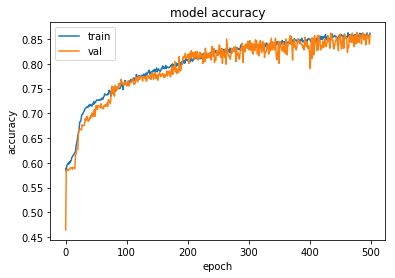

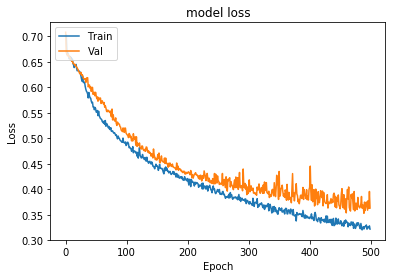

In [41]:
#plot_graph(history)
plot_graph_train_val(history)

In [21]:
def model_6(dim):
    model=Sequential()
    model.add(Dense(1000,input_dim=dim,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(300,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [22]:
def model_5(dim):
    model=Sequential()
    model.add(Dense(1024,input_dim=dim,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(768,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(512,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(256,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(128,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [23]:
def model_4(dim):
    model=Sequential()
    model.add(Dense(1024,input_dim=dim,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(768,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(512,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(256,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [24]:
def model_3(dim):
    model=Sequential()
    model.add(Dense(1024,input_dim=dim,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(768,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(512,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [25]:
def model_2(dim):
    model=Sequential()
    model.add(Dense(1024,input_dim=dim,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(768,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [26]:
def model_1(dim):
    model=Sequential()
    model.add(Dense(1024,input_dim=dim,activation='relu'))  
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [27]:
def final_model(dim):
    model=Sequential()
    model.add(Dense(1000,input_dim=dim,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(700,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(300,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [ ]:
def Smote_imbalance():
    X,y=scaledData.iloc[:,0:10], data.type.astype("str")
    print(Counter(y))
    sm = SMOTE(random_state=42)
    X1, y1 = sm.fit_resample(X, y)
    X= pd.DataFrame(data = X1, columns=X.columns) 
    y=pd.DataFrame.from_records(y1)
    print(Counter(y1))
    return X,y

In [28]:
def plot_graph_train(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

In [29]:
def plot_graph_train_val(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [30]:
def calculate_scores(y_true,y_pred):
    acc=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred, average='weighted')
    f1=f1_score(y_true, y_pred, average='weighted')
    print('Accuracy=',acc)
    print('Precision=',precision)
    print('F1Score=',f1)
    return acc,precision,f1
def calculate_scores2(y_true,y_pred):
    acc=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred, average='weighted')
    f1=f1_score(y_true, y_pred, average='weighted')
    #print('Accuracy=',acc)
    #print('Precision=',precision)
    #print('F1Score=',f1)
    return acc,precision,f1

In [33]:
from sklearn.model_selection import StratifiedKFold, KFold
# K-fold Cross Validation model evaluation

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []



# Define the K-fold Cross Validator
#kfold = KFold(n_splits=5, random_state=42, shuffle=False)
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)
fold_no = 1 

accuracy_scores=[]
f1_scores=[]
precision_scores=[]
recall_scores=[]
r2_score=[]
mcc_scores=[]
brier_scores=[]
ckappa_scores=[]


X,y=scaledData.iloc[:,0:10], data.type.astype("str")
#X,y=scaledData.iloc[:,0:9], data.type.astype("str")
#X,y=Smote_imbalance()
#X,y=X_train,y_train
for train_index, test_index in skf.split(X,y):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index] 
  #X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] 
  #print(X_train.head())
  #X_train,y_train=X.iloc[train_index],y.iloc[train_index]
  print(Counter(y_train),Counter(y_test))  
  # Define the model architecture  
  model=final_model(10)
  #model = Sequential()
  #model.add(Dense(1000,input_dim=10,activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(700,activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(500,activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(300,activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(100,activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...') 
  sm = SMOTE(random_state=42)
  #X_train, y_train = sm.fit_resample(X_train, y_train)
  #X_test, y_test = sm.fit_resample(X_test, y_test)  
  print(Counter(y_train),Counter(y_test))  
  # Fit data to model
  history = model.fit(X_train, y_train,batch_size=100,epochs=500,verbose=0)
  
  y_pred = model.predict(X_test)
  #y_pred=np.argmax(y_pred,axis=-1)
  y_pred=np.where(y_pred> 0.5, 1, 0)
  #print(y_pred[0:5])
  y_true=y_test.astype('int64')
  #s=scoreset(y_true,y_pred)
  acc,precision,f1=calculate_scores(y_true, y_pred)
  accuracy_scores.append(acc)
  f1_scores.append(f1)
  precision_scores.append(precision)  
  #plot_graph_train(history)  
  # Increase fold number
  fold_no = fold_no + 1

print("The mean value of accuracy is",np.mean(accuracy_scores)) 
print("The mean value of precision is",np.mean(f1_scores))
print("The mean value of F1 score is",np.mean(precision_scores))

Counter({'0': 3752, '1': 2512}) Counter({'0': 939, '1': 629})
------------------------------------------------------------------------
Training for fold 1 ...
Counter({'0': 3752, '1': 2512}) Counter({'0': 939, '1': 629})
Accuracy= 0.875
Precision= 0.8756269717133692
F1Score= 0.8736613431104483
Counter({'0': 3753, '1': 2513}) Counter({'0': 938, '1': 628})
------------------------------------------------------------------------
Training for fold 2 ...
Counter({'0': 3753, '1': 2513}) Counter({'0': 938, '1': 628})
Accuracy= 0.8754789272030651
Precision= 0.8751316710077431
F1Score= 0.8747933515644938
Counter({'0': 3753, '1': 2513}) Counter({'0': 938, '1': 628})
------------------------------------------------------------------------
Training for fold 3 ...
Counter({'0': 3753, '1': 2513}) Counter({'0': 938, '1': 628})
Accuracy= 0.855683269476373
Precision= 0.856554660406295
F1Score= 0.856003716985651
Counter({'0': 3753, '1': 2513}) Counter({'0': 938, '1': 628})
------------------------------

In [32]:
###############################################################################
from sklearn.model_selection import StratifiedKFold, KFold
# K-fold Cross Validation model evaluation

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []



# Define the K-fold Cross Validator
#kfold = KFold(n_splits=5, random_state=42, shuffle=False)
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)
fold_no = 1 

accuracy_scores=[]
f1_scores=[]
precision_scores=[]
recall_scores=[]
r2_score=[]
mcc_scores=[]
brier_scores=[]
ckappa_scores=[]


X,y=scaledData.iloc[:,0:10], data.type.astype("str")
#X,y=scaledData.iloc[:,0:9], data.type.astype("str")
#X,y=Smote_imbalance()
#X,y=X_train,y_train
for i in range(5,8):
    for train_index, test_index in skf.split(X,y):
      X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index] 
      #print(Counter(y_train),Counter(y_test))  
      
      #model=final_model(10)
      #model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])

      # Generate a print
      #print('------------------------------------------------------------------------')
      #print(f'Training for fold {fold_no} ...')   
      #print(Counter(y_train),Counter(y_test))  
      # Fit data to model
      if(i==1):
        model=model_1(10)
      elif (i==2):
        model=model_2(10)
      elif (i==3):
        model=model_3(10)
      elif (i==4):
        model=model_4(10)
      elif (i==5):
        model=model_5(10)
      elif (i==6):
        model=model_6(10)
      elif (i==7):
        model=final_model(10)
        
      model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])
      history = model.fit(X_train, y_train,batch_size=100,epochs=500,verbose=0)
  
      y_pred = model.predict(X_test)
      #y_pred=np.argmax(y_pred,axis=-1)
      y_pred=np.where(y_pred> 0.5, 1, 0)
      #print(y_pred[0:5])
      y_true=y_test.astype('int64')
      #s=scoreset(y_true,y_pred)
      acc,precision,f1=calculate_scores2(y_true, y_pred)
      accuracy_scores.append(acc)
      f1_scores.append(f1)
      precision_scores.append(precision)  
      #plot_graph_train(history)  
      # Increase fold number
      fold_no = fold_no + 1
    print("For model",i)
    print("The mean value of accuracy is",np.mean(accuracy_scores)) 
    print("The mean value of precision is",np.mean(f1_scores))
    print("The mean value of F1 score is",np.mean(precision_scores))
    print(" ")

For model 5
The mean value of accuracy is 0.8659290536137826
The mean value of precision is 0.8661241981936811
The mean value of F1 score is 0.8698857163553739
 
For model 6
The mean value of accuracy is 0.8525218612349155
The mean value of precision is 0.8528931098605594
The mean value of F1 score is 0.856185833223081
 
For model 7
The mean value of accuracy is 0.8540563830896344
The mean value of precision is 0.8544255146884322
The mean value of F1 score is 0.8576607209163138
 


In [ ]:
##test dataset
y_pred = model.predict(X_test)
#y_pred=np.argmax(y_pred,axis=-1)
y_pred=np.where(y_pred> 0.5, 1, 0)
#print(y_pred[0:5])
y_true=y_test
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score
#tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
acc=accuracy_score(y_true, y_pred)
precision=precision_score(y_true, y_pred, average='weighted')
f1=f1_score(y_true, y_pred, average='weighted')
print('Accuracy=',acc)
print('Precision=',precision)
print('F1Score=',f1)
print('tn, fp, fn, tp' )

from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['0','1'])
print(report)
print(confusion_matrix(y_true,y_pred))


# Conclusions

**Great 💪🤖!!**, now we have seen the two approaches to analyze a cyber threat. Of course we can use a lot of variables that in this case we didn't use them, for example netflows, methods callings, graph analysis, and many others, but the idea behind this work is to understand that we need to pay attention of all of the environments because when we are working in **cybersecurity** we face with a **complex problem**. 

# References

+ [1] López, U., Camilo, C., García Peña, M., Osorio Quintero, J. L., & Navarro Cadavid, A. (2018). Ciberseguridad: un enfoque desde la ciencia de datos-Primera edición.
+ [2] Navarro Cadavid, A., Londoño, S., Urcuqui López, C. C., & Gomez, J. (2014, June). Análisis y caracterización de frameworks para detección de aplicaciones maliciosas en Android. In Conference: XIV Jornada Internacional de Seguridad Informática ACIS-2014 (Vol. 14). ResearchGate.
+ [3] Urcuqui-López, C., & Cadavid, A. N. (2016). Framework for malware analysis in Android.
+ [4] Urcuqui,  C.,  Navarro,  A.,  Osorio,  J.,  &  Garcıa,  M.  (2017). Machine Learning  Classifiers  to  Detect  Malicious  Websites. CEUR  Workshop Proceedings. Vol 1950, 14-17.
+ [5] López, C. C. U., Villarreal, J. S. D., Belalcazar, A. F. P., Cadavid, A. N., & Cely, J. G. D. (2018, May). Features to Detect Android Malware. In 2018 IEEE Colombian Conference on Communications and Computing (COLCOM) (pp. 1-6). IEEE.